In [1]:
import numpy as np 
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import copy, os, sys

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


f:\developer\Anaconda\envs\Time_fore\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 构建模型

In [40]:
#LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1
        self.batch_size = batch_size
        self.lstm = nn.LSTM((self.input_size), (self.hidden_size), (self.num_layers), batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input_seq):
        batch_size, seq_len = input_seq.shape[0], input_seq.shape[1]
        h_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        output, _ = self.lstm(input_seq, (h_0, c_0))
        pred = self.linear(output)
        pred = pred[:, -1, :] # 对于每一个批次，我们选择最后一个时间步的所有输出特征,张量维度：(batch_size, sequence_length, output_size)
        return pred

#双LSTM层
class LSTM_2cells(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.input_size = args.input_size
        self.output_size = args.output_size
        self.num_directions = 1
        self.batch_size = args.batch_size
        self.lstm0 = nn.LSTMCell(args.input_size, hidden_size=128)
        self.lstm1 = nn.LSTMCell(input_size=128, hidden_size=32)
        self.dropout = nn.Dropout(p=0.4)
        self.linear = nn.Linear(32, self.output_size)

    def forward(self, input_seq):
        batch_size, seq_len = input_seq.shape[0], input_seq.shape[1]
        # batch_size, hidden_size
        h_l0 = torch.zeros(batch_size, 128).to(device)
        c_l0 = torch.zeros(batch_size, 128).to(device)
        h_l1 = torch.zeros(batch_size, 32).to(device)
        c_l1 = torch.zeros(batch_size, 32).to(device)
        output = []
        for t in range(seq_len):
            h_l0, c_l0 = self.lstm0(input_seq[:, t, :], (h_l0, c_l0))
            h_l0, c_l0 = self.dropout(h_l0), self.dropout(c_l0)
            h_l1, c_l1 = self.lstm1(h_l0, (h_l1, c_l1))
            h_l1, c_l1 = self.dropout(h_l1), self.dropout(c_l1)
            output.append(h_l1)

        pred = self.linear(output[-1])

        return pred



#双向LSTM（模型在初始化隐藏状态 h o 和 c时，使用了固定的批量大小self.batch size 。这意味着，无论输入数据的批量大小是多少，隐藏状态的批量大小总是固定的。这就是为什么当输入数据的批量大小不等于self.batch size 时，你会遇到问题）
# class BiLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size):
#         super().__init__()
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.output_size = output_size
#         self.num_directions = 2
#         self.batch_size = batch_size
#         self.lstm = nn.LSTM((self.input_size), (self.hidden_size), (self.num_layers), batch_first=True, bidirectional=True)
#         self.linear = nn.Linear(self.num_directions * self.hidden_size, self.output_size)

#     def forward(self, input_seq):
#         h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
#         c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
#         # print(input_seq.size())
#         seq_len = input_seq.shape[1]
#         # input(batch_size, seq_len, input_size)
#         # output(batch_size, seq_len, num_directions * hidden_size)
#         output, _ = self.lstm(input_seq, (h_0, c_0))
#         pred = self.linear(output)  # pred()
#         pred = pred[:, -1, :]
        
#         return pred
    
class BiLSTM(nn.Module):#(在前向传播时.通过 input seq.size(o)动态地获取批量大小，然后用这个批量大小来初始化隐藏状态,避免最后一个批次样本量不足时，导致批次大小和预期的不匹配)
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 2
        self.lstm = nn.LSTM((self.input_size), (self.hidden_size), (self.num_layers), batch_first=True, bidirectional=True)
        self.linear = nn.Linear(self.num_directions * self.hidden_size, self.output_size)

    def forward(self, input_seq):
        batch_size = input_seq.size(0)  # 动态获取批量大小
        h_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        output, _ = self.lstm(input_seq, (h_0, c_0))
        pred = self.linear(output)
        pred = pred[:, -1, :]
        
        return pred

#编码器，采用了LSTM将原始数据进行编码，然后将LSTM的最后的隐状态和单元状态返回。
class Encoder(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 1
        self.batch_size = batch_size
        self.lstm = nn.LSTM((self.input_size), (self.hidden_size), (self.num_layers), batch_first=True, bidirectional=False)

    def forward(self, input_seq):
        batch_size, seq_len = input_seq.shape[0], input_seq.shape[1]
        h_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        output, (h, c) = self.lstm(input_seq, (h_0, c_0))
        return (
         h, c)

#解码器，解码器同样也由LSTM组成，不过解码器的初始的隐状态和单元状态是编码器的输出。此外，解码器每次输入都是上次的输出。
class Decoder(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1
        self.batch_size = batch_size
        self.lstm = nn.LSTM((self.input_size), (self.hidden_size), (self.num_layers), batch_first=True, bidirectional=False)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input_seq, h, c):
        batch_size = input_seq.shape[0]
        input_seq = input_seq.view(batch_size, 1, self.input_size)
        output, (h, c) = self.lstm(input_seq, (h, c))
        pred = self.linear(output)
        pred = pred[:, -1, :]
        return (
         pred, h, c)

#seq2seq
class Seq2Seq(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size):
        super().__init__()
        self.output_size = output_size
        self.Encoder = Encoder(input_size, hidden_size, num_layers, batch_size)
        self.Decoder = Decoder(input_size, hidden_size, num_layers, output_size, batch_size)

    def forward(self, input_seq):
        batch_size, seq_len, _ = input_seq.shape[0], input_seq.shape[1], input_seq.shape[2]
        h, c = self.Encoder(input_seq)
        outputs = torch.zeros(batch_size, seq_len, self.output_size).to(device)
        for t in range(seq_len):
            _input = input_seq[:, t, :]
            output, h, c = self.Decoder(_input, h, c)
            outputs[:, t, :] = output

        return outputs[:, -1, :]

#多任务学习LSTM
class MTL_LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size, n_outputs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1
        self.n_outputs = n_outputs
        self.batch_size = batch_size
        self.lstm = nn.LSTM((self.input_size), (self.hidden_size), (self.num_layers), batch_first=True)
        self.fc1 = nn.Linear(self.hidden_size, self.output_size)
        self.fc2 = nn.Linear(self.hidden_size, self.output_size)
        self.fc3 = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input_seq):
        batch_size, seq_len = input_seq.shape[0], input_seq.shape[1]
        h_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        output, _ = self.lstm(input_seq, (h_0, c_0))
        preds = []
        pred1, pred2, pred3 = self.fc1(output), self.fc2(output), self.fc3(output)
        pred1, pred2, pred3 = pred1[:, -1, :], pred2[:, -1, :], pred3[:, -1, :]
        pred = torch.stack([pred1, pred2, pred3], dim=0)
        return pred

# 数据集和特征处理部分

In [3]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return len(self.data)

In [4]:
# # 读取数据，填充缺失值
# def load_data(file_name):
#     df = pd.read_csv(r'../data/' + file_name, encoding='gbk')
#     num_cols = df.columns[1:]  # 获取除第0列外的每一列名称(第0列的时间类型无法求均值)
#     df[num_cols].fillna(df[num_cols].mean(), inplace=True) #填补缺失值
#     return df

# 加载数据，填充缺失值
def load_data(file_name):
    """
    :return: dataframe
    """
    path = os.path.dirname(os.getcwd()) + '/data/' + file_name
    df = pd.read_csv(path, encoding='gbk')
    num_cols = df.columns[1:]  # 获取除第0列外的每一列名称(第0列的时间类型无法求均值)
    df[num_cols].fillna(df[num_cols].mean(), inplace=True) #填补缺失值
    return df

In [52]:
# 根据flag选择处理数据,返回训练集、验证集、测试集、最大值、最小值
def data_process(dataset,args, flag):
    if flag == 'us':
        Dtr, Val, Dte, m, n = nn_seq_us(dataset,seq_len=(args.seq_len), B=(args.batch_size))
    elif flag == 'ms':
        Dtr, Val, Dte, m, n = nn_seq_ms(dataset,seq_len=(args.seq_len), B=(args.batch_size))
    elif flag == 'mm':
        Dtr, Val, Dte, m, n = nn_seq_mm(dataset,seq_len=(args.seq_len), B=(args.batch_size), num=(args.output_size))
    elif flag == 'mms' or flag == 'mmss':
        Dtr, Val, Dte, m, n = nn_seq_mmss(dataset,seq_len=(args.seq_len), B=(args.batch_size), pred_step_size=(args.pred_step_size))
    elif flag == 'mo' or flag == 'seq2seq':
        Dtr, Val, Dte, m, n = nn_seq_mo(dataset,seq_len=(args.seq_len), B=(args.batch_size), num=(args.output_size))
    elif flag == 'sss':#单步滚动预测
        Dtr, Val, Dte, m, n = nn_seq_sss(dataset,seq_len=(args.seq_len), B=(args.batch_size))

    return (Dtr, Val, Dte, m, n)

def get_mape(x, y):#计算平均绝对百分比误差MAPE
    """
    :param x: true value
    :param y: pred value
    :return: mape
    """
    return np.mean(np.abs((x - y) / x))

# 单变量单步 处理数据
def nn_seq_us(dataset,seq_len, B):
    print('data processing...')
    train = dataset[:int(len(dataset) * 0.6)]
    val = dataset[int(len(dataset) * 0.6):int(len(dataset) * 0.8)]
    test = dataset[int(len(dataset) * 0.8):len(dataset)]
    m, n = np.max(train[train.columns[1]]), np.min(train[train.columns[1]])

    def process(data, batch_size):
        load = data[data.columns[1]]
        data = data.values.tolist()
        load = (load - n) / (m - n)
        load = load.tolist()
        seq = []
        for i in range(len(data) - seq_len):
            train_seq = []
            train_label = []
            for j in range(i, i + seq_len):
                x = [
                 load[j]]
                train_seq.append(x)

            train_label.append(load[(i + seq_len)])
            train_seq = torch.FloatTensor(train_seq)
            train_label = torch.FloatTensor(train_label).view(-1)
            seq.append((train_seq, train_label))

        seq = MyDataset(seq)
        seq = DataLoader(dataset=seq, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False)
        return seq

    Dtr = process(train, B)
    Val = process(val, B)
    Dte = process(test, B)
    return (
     Dtr, Val, Dte, m, n)

# 多变量单步 处理数据
def nn_seq_ms(dataset,seq_len, B):
    print('data processing...')
    train = dataset[:int(len(dataset) * 0.6)]
    val = dataset[int(len(dataset) * 0.6):int(len(dataset) * 0.8)]
    test = dataset[int(len(dataset) * 0.8):len(dataset)]
    m, n = np.max(train[train.columns[1]]), np.min(train[train.columns[1]])

    def process(data, batch_size):
        load = data[data.columns[1]]
        data = data.values.tolist()
        load = (load - n) / (m - n)
        load = load.tolist()
        seq = []
        for i in range(len(data) - seq_len):
            train_seq = []
            train_label = []
            for j in range(i, i + seq_len):
                x = [
                 load[j]]
                for c in range(2, 8):
                    x.append(data[j][c])

                train_seq.append(x) 

            train_label.append(load[(i + seq_len)])
            train_seq = torch.FloatTensor(train_seq)
            train_label = torch.FloatTensor(train_label).view(-1)
            seq.append((train_seq, train_label))

        seq = MyDataset(seq)
        seq = DataLoader(dataset=seq, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False) #最后一个批次不满足30
        return seq

    Dtr = process(train, B)
    Val = process(val, B)
    Dte = process(test, B)
    return (
     Dtr, Val, Dte, m, n)

# 多变量多步 处理数据
def nn_seq_mm(dataset,seq_len, B, num): #num为预测步长
    print('data processing...')
    train = dataset[:int(len(dataset) * 0.6)]
    val = dataset[int(len(dataset) * 0.6):int(len(dataset) * 0.8)]
    test = dataset[int(len(dataset) * 0.8):len(dataset)]
    m, n = np.max(train[train.columns[1]]), np.min(train[train.columns[1]])

    def process(data, batch_size, step_size):
        load = data[data.columns[1]]
        data = data.values.tolist()
        load = (load - n) / (m - n)
        load = load.tolist()
        # 根据给定的步长 step_size，从数据集中提取输入序列和对应的目标标签
        seq = []
        for i in range(0, len(data) - seq_len - num, step_size):
            train_seq = []
            train_label = []
            for j in range(i, i + seq_len):
                x = [
                 load[j]]
                for c in range(2, 8):
                    x.append(data[j][c])

                train_seq.append(x)

            for j in range(i + seq_len, i + seq_len + num):
                train_label.append(load[j])

            train_seq = torch.FloatTensor(train_seq)
            train_label = torch.FloatTensor(train_label).view(-1)
            seq.append((train_seq, train_label))

        seq = MyDataset(seq)
        seq = DataLoader(dataset=seq, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False)
        return seq

    Dtr = process(train, B, step_size=1)
    Val = process(val, B, step_size=1)
    Dte = process(test, B, step_size=num)
    return (
     Dtr, Val, Dte, m, n)

#seq2seq和直接多输出
def nn_seq_mo(data,seq_len, B, num):
    # 数据划分
    train = data[:int(len(data) * 0.6)]
    val = data[int(len(data) * 0.6):int(len(data) * 0.8)]
    test = data[int(len(data) * 0.8):len(data)]
    m, n = np.max(train[train.columns[1]]), np.min(train[train.columns[1]])

    def process(dataset, batch_size, step_size):
        load = dataset[dataset.columns[1]]
        load = (load - n) / (m - n)  # 归一化
        load = load.tolist()
        dataset = dataset.values.tolist()
        #序列和标签
        seq = []
        for i in range(0, len(dataset) - seq_len - num, step_size):
            train_seq = []
            train_label = []
            for j in range(i, i + seq_len):
                x = [
                 load[j]]
                for c in range(2, 8):
                    x.append(dataset[j][c])

                train_seq.append(x)

            for j in range(i + seq_len, i + seq_len + num):
                train_label.append(load[j])
            #pytorch张量
            train_seq = torch.FloatTensor(train_seq)
            train_label = torch.FloatTensor(train_label).view(-1)
            seq.append((train_seq, train_label))

        seq = MyDataset(seq)
        seq = DataLoader(dataset=seq, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
        return seq

    Dtr = process(train, B, step_size=1)
    Val = process(val, B, step_size=1)
    Dte = process(test, B, step_size=num)
    return (
     Dtr, Val, Dte, m, n)

#单步滚动预测
def nn_seq_sss(data,seq_len, B):
    train = data[:int(len(data) * 0.6)]
    val = data[int(len(data) * 0.6):int(len(data) * 0.8)]
    test = data[int(len(data) * 0.8):len(data)]
    m, n = np.max(train[train.columns[1]]), np.min(train[train.columns[1]])

    def process(dataset, batch_size):
        load = dataset[dataset.columns[1]]
        load = (load - n) / (m - n)
        load = load.tolist()
        dataset = dataset.values.tolist()
        seq = []
        for i in range(len(dataset) - seq_len):
            train_seq = []
            train_label = []
            for j in range(i, i + seq_len):
                x = [
                 load[j]]
                for c in range(2, 8):
                    x.append(dataset[j][c])

                train_seq.append(x)

            train_label.append(load[(i + seq_len)])
            train_seq = torch.FloatTensor(train_seq)
            train_label = torch.FloatTensor(train_label).view(-1)
            seq.append((train_seq, train_label))

        seq = MyDataset(seq)
        seq = DataLoader(dataset=seq, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
        return seq

    Dtr = process(train, B)
    Val = process(val, B)
    Dte = process(test, B)
    return (
     Dtr, Val, Dte, m, n)

#多模型滚动和多模型
def nn_seq_mmss(data,seq_len, B, pred_step_size):
    train = data[:int(len(data) * 0.6)]
    val = data[int(len(data) * 0.6):int(len(data) * 0.8)]
    test = data[int(len(data) * 0.8):len(data)]
    m, n = np.max(train[train.columns[1]]), np.min(train[train.columns[1]])

    def process(dataset, batch_size, step_size):
        load = dataset[dataset.columns[1]]
        load = (load - n) / (m - n)
        dataset = dataset.values.tolist()
        load = load.tolist()
        seqs = [[] for i in range(pred_step_size)]
        for i in range(0, len(dataset) - seq_len - pred_step_size, step_size):
            train_seq = []
            for j in range(i, i + seq_len):
                x = [
                 load[j]]
                for c in range(2, 8):
                    x.append(dataset[j][c])

                train_seq.append(x)

            for j, ind in zip(range(i + seq_len, i + seq_len + pred_step_size), range(pred_step_size)):
                train_label = [
                 load[j]]
                seq = torch.FloatTensor(train_seq)
                train_label = torch.FloatTensor(train_label).view(-1)
                seqs[ind].append((seq, train_label))

        res = []
        for seq in seqs:
            seq = MyDataset(seq)
            seq = DataLoader(dataset=seq, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
            res.append(seq)

        return res

    Dtrs = process(train, B, step_size=1)
    Vals = process(val, B, step_size=1)
    Dtes = process(test, B, step_size=pred_step_size)
    return (
     Dtrs, Vals, Dtes, m, n)

#多任务学习
def nn_seq_mtl(data,seq_len, B, pred_step_size):
    #data = load_data('mtl_data_1.csv')
    train = data[:int(len(data) * 0.6)]
    val = data[int(len(data) * 0.6):int(len(data) * 0.8)]
    test = data[int(len(data) * 0.8):len(data)]
    train.drop([train.columns[0]], axis=1, inplace=True)
    val.drop([val.columns[0]], axis=1, inplace=True)
    test.drop([test.columns[0]], axis=1, inplace=True)
    scaler = MinMaxScaler()
    train = scaler.fit_transform(train.values)
    val = scaler.transform(val.values)
    test = scaler.transform(test.values)

    def process(dataset, batch_size, step_size):
        dataset = dataset.tolist()
        seq = []
        for i in range(0, len(dataset) - seq_len - pred_step_size, step_size):
            train_seq = []
            for j in range(i, i + seq_len):
                x = []
                for c in range(len(dataset[0])):
                    x.append(dataset[j][c])

                train_seq.append(x)

            train_labels = []
            for j in range(len(dataset[0])):
                train_label = []
                for k in range(i + seq_len, i + seq_len + pred_step_size):
                    train_label.append(dataset[k][j])

                train_labels.append(train_label)

            train_seq = torch.FloatTensor(train_seq)
            train_labels = torch.FloatTensor(train_labels)
            seq.append((train_seq, train_labels))

        seq = MyDataset(seq)
        seq = DataLoader(dataset=seq, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
        return seq

    Dtr = process(train, B, step_size=1)
    Val = process(val, B, step_size=1)
    Dte = process(test, B, step_size=pred_step_size)
    return (
     Dtr, Val, Dte, scaler)


In [6]:
# 计算验证集的损失值
def get_val_loss(args, model, Val):
    model.eval()
    loss_function = nn.MSELoss().to(args.device)
    val_loss = []
    for seq, label in Val:
        with torch.no_grad():
            seq = seq.to(args.device)
            label = label.to(args.device)
            y_pred = model(seq)
            loss = loss_function(y_pred, label)
            val_loss.append(loss.item())

    return np.mean(val_loss)

In [7]:
import random
# 用于设置随机种子，以确保在训练模型时的可重复性
def setup_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [44]:
# 训练模型并保存最佳模型

def train(args, Dtr, Val,path,cells=0):
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size
    if args.bidirectional:
        model = BiLSTM(input_size, hidden_size, num_layers, output_size).to(device)
    else:
        model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=(args.batch_size)).to(device)
    if cells == 1: #多层LSTM
        model = LSTM_2cells(args).to(device)
    loss_function = nn.MSELoss().to(device)
    if args.optimizer == 'adam':
        optimizer = torch.optim.Adam((model.parameters()), lr=(args.lr), weight_decay=(args.weight_decay))
    else:
        optimizer = torch.optim.SGD((model.parameters()), lr=(args.lr), momentum=0.9,
          weight_decay=(args.weight_decay))
    scheduler = StepLR(optimizer, step_size=(args.step_size), gamma=(args.gamma))
    min_epochs = 10
    best_model = None
    min_val_loss = 5
    for epoch in tqdm(range(args.epochs)):
        train_loss = []
        for seq, label in Dtr:
            seq = seq.to(device)
            label = label.to(device)
            #print("Seq 的大小:", seq.size())  # 打印 seq 的大小
            y_pred = model(seq)
            loss = loss_function(y_pred, label)
            train_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        scheduler.step()
        val_loss = get_val_loss(args, model, Val)
        if epoch + 1 >= min_epochs:
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                best_model = copy.deepcopy(model)
        if (epoch + 1) % 50 == 0:
            print('epoch {:03d} train_loss {:.8f} val_loss {:.8f}'.format(epoch, np.mean(train_loss), val_loss))
        model.train()

    state = {'models': best_model.state_dict()}
    torch.save(state, path)

#seq2seq的训练函数
def seq2seq_train(args, Dtr, Val, path):
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size
    batch_size = args.batch_size
    model = Seq2Seq(input_size, hidden_size, num_layers, output_size, batch_size=batch_size).to(device)
    loss_function = nn.MSELoss().to(device)
    if args.optimizer == 'adam':
        optimizer = torch.optim.Adam((model.parameters()), lr=(args.lr), weight_decay=(args.weight_decay))
    else:
        optimizer = torch.optim.SGD((model.parameters()), lr=(args.lr), momentum=0.9,
          weight_decay=(args.weight_decay))
    scheduler = StepLR(optimizer, step_size=(args.step_size), gamma=(args.gamma))
    min_epochs = 10
    best_model = None
    min_val_loss = 5
    for epoch in tqdm(range(args.epochs)):
        train_loss = []
        for seq, label in Dtr:
            seq = seq.to(device)
            label = label.to(device)
            y_pred = model(seq)
            loss = loss_function(y_pred, label)
            train_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        scheduler.step()
        val_loss = get_val_loss(args, model, Val)
        if epoch > min_epochs:
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                best_model = copy.deepcopy(model)
        print('epoch {:03d} train_loss {:.8f} val_loss {:.8f}'.format(epoch, np.mean(train_loss), val_loss))
        model.train()

    state = {'models': best_model.state_dict()}
    torch.save(state, path)

#多任务学习的训练函数
def mtl_train(args, Dtr, Val, path):
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size
    model = MTL_LSTM(input_size, hidden_size, num_layers, output_size, batch_size=(args.batch_size), n_outputs=(args.n_outputs)).to(device)
    loss_function = nn.MSELoss().to(device)
    if args.optimizer == 'adam':
        optimizer = torch.optim.Adam((model.parameters()), lr=(args.lr), weight_decay=(args.weight_decay))
    else:
        optimizer = torch.optim.SGD((model.parameters()), lr=(args.lr), momentum=0.9,
          weight_decay=(args.weight_decay))
    scheduler = StepLR(optimizer, step_size=(args.step_size), gamma=(args.gamma))
    min_epochs = 10
    best_model = None
    min_val_loss = 5
    for epoch in tqdm(range(args.epochs)):
        train_loss = []
        for seq, labels in Dtr:
            seq = seq.to(device)
            labels = labels.to(device)
            preds = model(seq)
            total_loss = 0
            for k in range(args.n_outputs):
                total_loss = total_loss + loss_function(preds[k, :, :], labels[:, k, :])

            total_loss /= preds.shape[0]
            train_loss.append(total_loss.item())
            total_loss.requires_grad_(True)
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        scheduler.step()
        val_loss = get_mtl_val_loss(args, model, Val)
        if epoch + 1 >= min_epochs:
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                best_model = copy.deepcopy(model)
        print('epoch {:03d} train_loss {:.8f} val_loss {:.8f}'.format(epoch, np.mean(train_loss), val_loss))
        model.train()

    state = {'models': best_model.state_dict()}
    torch.save(state, path)


In [47]:
from itertools import chain
from scipy.interpolate import make_interp_spline

# 测试模型并进行预测
def test(args, Dte, path, m, n,cells=0):
    pred = []
    y = []
    print('loading models...')
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size
    if args.bidirectional:
        model = BiLSTM(input_size, hidden_size, num_layers, output_size).to(device)
    else:
        model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=(args.batch_size)).to(device)
    if cells == 1:
        model = LSTM_2cells(args).to(device)
    model.load_state_dict(torch.load(path)['models'])
    model.eval()
    print('predicting...')
    for seq, target in tqdm(Dte):
        target = list(chain.from_iterable(target.data.tolist()))
        y.extend(target)
        seq = seq.to(device)
        with torch.no_grad():
            y_pred = model(seq)
            y_pred = list(chain.from_iterable(y_pred.data.tolist()))
            pred.extend(y_pred)

    y, pred = np.array(y), np.array(pred)
    y = (m - n) * y + n
    pred = (m - n) * pred + n
    print('mape:', get_mape(y, pred))
    x = [i for i in range(1, 151)]
    x_smooth = np.linspace(np.min(x), np.max(x), 900)
    y_smooth = make_interp_spline(x, y[150:300])(x_smooth)
    plt.plot(x_smooth, y_smooth, c='green', marker='*', ms=1, alpha=0.75, label='true')
    y_smooth = make_interp_spline(x, pred[150:300])(x_smooth)
    plt.plot(x_smooth, y_smooth, c='red', marker='o', ms=1, alpha=0.75, label='pred')
    plt.grid(axis='y')
    plt.legend()
    #os.environ['KMP_DUPLICATE_LIB_OK']='True'
    plt.savefig(r"../result/单步单变量预测.png")
    plt.show()


In [62]:
#多模型单步
def m_test(args, Dtes, PATHS, m, n):
    pred = []
    y = []
    print('loading models...')
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size
    Dtes = [[x for x in iter(Dte)] for Dte in Dtes]
    models = []

    #遍历模型，要评估12个模型
    for path in PATHS:
        if args.bidirectional:
            model = BiLSTM(input_size, hidden_size, num_layers, output_size, batch_size=(args.batch_size)).to(device)
        else:
            model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=(args.batch_size)).to(device)
        model.load_state_dict(torch.load(path)['models'])
        model.eval()
        models.append(model)

    print('predicting...')
    for i in range(len(Dtes[0])):
        for j in range(len(Dtes)):
            model = models[j]
            seq, label = Dtes[j][i][0], Dtes[j][i][1]
            label = list(chain.from_iterable(label.data.tolist()))
            y.extend(label)
            seq = seq.to(device)
            with torch.no_grad():
                y_pred = model(seq)
                y_pred = list(chain.from_iterable(y_pred.data.tolist()))
                pred.extend(y_pred)

    y, pred = np.array(y), np.array(pred)
    y = (m - n) * y + n
    pred = (m - n) * pred + n
    print('mape:', get_mape(y, pred))
    plot(y, pred)

#seq2seq
def seq2seq_test(args, Dte, path, m, n):
    pred = []
    y = []
    print('loading models...')
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size
    model = Seq2Seq(input_size, hidden_size, num_layers, output_size, batch_size=(args.batch_size)).to(device)
    model.load_state_dict(torch.load(path)['models'])
    model.eval()
    print('predicting...')
    for seq, target in tqdm(Dte):
        target = list(chain.from_iterable(target.data.tolist()))
        y.extend(target)
        seq = seq.to(device)
        with torch.no_grad():
            y_pred = model(seq)
            y_pred = list(chain.from_iterable(y_pred.data.tolist()))
            pred.extend(y_pred)

    y, pred = np.array(y), np.array(pred)
    y = (m - n) * y + n
    pred = (m - n) * pred + n
    print('mape:', get_mape(y, pred))
    plot(y, pred)

#将列表data中的数据每seq_len划分为一组，对应到本文中就是每12个batch的数据为一组。
def list_of_groups(data, sub_len):
    groups = zip(*(iter(data),) * sub_len)
    end_list = [list(i) for i in groups]
    count = len(data) % sub_len
    end_list.append(data[-count:]) if count != 0 else end_list
    return end_list

#单步滚动
def ss_rolling_test(args, Dte, path, m, n):
    """
    :param args:
    :param Dte:
    :param path:
    :param m:
    :param n:
    :return:
    """
    pred = []
    y = []
    print('loading models...')
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size
    if args.bidirectional:
        model = BiLSTM(input_size, hidden_size, num_layers, output_size, batch_size=(args.batch_size)).to(device)
    else:
        model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=(args.batch_size)).to(device)
    model.load_state_dict(torch.load(path)['models'])
    model.eval()
    print('predicting...')
    Dte = [x for x in iter(Dte)]
    Dte = list_of_groups(Dte, args.pred_step_size)
    for sub_item in tqdm(Dte):
        sub_pred = []
        for seq_idx, (seq, label) in enumerate(sub_item, 0):
            label = list(chain.from_iterable(label.data.tolist()))
            y.extend(label)
            if seq_idx != 0:
                seq = seq.cpu().numpy().tolist()[0]
                if len(sub_pred) >= len(seq):
                    for t in range(len(seq)):
                        seq[t][0] = sub_pred[(len(sub_pred) - len(seq) + t)]

                else:
                    for t in range(len(sub_pred)):
                        seq[(len(seq) - len(sub_pred) + t)][0] = sub_pred[t]

            else:
                seq = seq.cpu().numpy().tolist()[0]
            seq = [seq]
            seq = torch.FloatTensor(seq)
            seq = MyDataset(seq)
            seq = DataLoader(dataset=seq, batch_size=1, shuffle=False, num_workers=0)
            seq = [x for x in iter(seq)][0]
            with torch.no_grad():
                seq = seq.to(device)
                y_pred = model(seq)
                y_pred = list(chain.from_iterable(y_pred.data.tolist()))
                sub_pred.extend(y_pred)

        pred.extend(sub_pred)

    y, pred = np.array(y), np.array(pred)
    y = (m - n) * y + n
    pred = (m - n) * pred + n
    print('mape:', get_mape(y, pred))
    plot(y, pred)

#多模型滚动
def mms_rolling_test(args, Dte, PATHS, m, n):
    pred = []
    y = []
    print('loading models...')
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size
    models = []
    #遍历模型，要评估12个模型
    for path in PATHS:
        if args.bidirectional:
            model = BiLSTM(input_size, hidden_size, num_layers, output_size, batch_size=(args.batch_size)).to(device)
        else:
            model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=(args.batch_size)).to(device)
        model.load_state_dict(torch.load(path)['models'])
        model.eval()
        models.append(model)

    Dte = [x for x in iter(Dte)]
    Dte = list_of_groups(Dte, args.pred_step_size)
    for sub_item in tqdm(Dte):
        sub_pred = []
        for seq_idx, (seq, label) in enumerate(sub_item, 0):
            model = models[seq_idx]
            label = list(chain.from_iterable(label.data.tolist()))
            y.extend(label)
            if seq_idx != 0:
                seq = seq.cpu().numpy().tolist()[0]
                if len(sub_pred) >= len(seq):
                    for t in range(len(seq)):
                        seq[t][0] = sub_pred[(len(sub_pred) - len(seq) + t)]

                else:
                    for t in range(len(sub_pred)):
                        seq[(len(seq) - len(sub_pred) + t)][0] = sub_pred[t]

            else:
                seq = seq.cpu().numpy().tolist()[0]
            seq = [seq]
            seq = torch.FloatTensor(seq)
            seq = MyDataset(seq)
            seq = DataLoader(dataset=seq, batch_size=1, shuffle=False, num_workers=0)
            seq = [x for x in iter(seq)][0]
            with torch.no_grad():
                seq = seq.to(device)
                y_pred = model(seq)
                y_pred = list(chain.from_iterable(y_pred.data.tolist()))
                sub_pred.extend(y_pred)

        pred.extend(sub_pred)

    y, pred = np.array(y), np.array(pred)
    y = (m - n) * y + n
    pred = (m - n) * pred + n
    print('mape:', get_mape(y, pred))
    plot(y, pred)

#多任务学习
def mtl_test(args, Dte, scaler, path):
    print('loading models...')
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size
    model = MTL_LSTM(input_size, hidden_size, num_layers, output_size, batch_size=(args.batch_size), n_outputs=(args.n_outputs)).to(device)
    model.load_state_dict(torch.load(path)['models'])
    model.eval()
    print('predicting...')
    ys = [[] for i in range(args.n_outputs)]
    preds = [[] for i in range(args.n_outputs)]
    for seq, targets in tqdm(Dte):
        targets = np.array(targets.data.tolist())
        for i in range(args.n_outputs):
            target = targets[:, i, :]
            target = list(chain.from_iterable(target))
            ys[i].extend(target)

        seq = seq.to(device)
        with torch.no_grad():
            _pred = model(seq)
            for i in range(_pred.shape[0]):
                pred = _pred[i]
                pred = list(chain.from_iterable(pred.data.tolist()))
                preds[i].extend(pred)

    ys, preds = np.array(ys).T, np.array(preds).T
    ys = scaler.inverse_transform(ys).T
    preds = scaler.inverse_transform(preds).T
    for ind, (y, pred) in enumerate(zip(ys, preds), 0):
        print(get_mape(y, pred))
        mtl_plot(y, pred, ind + 1)

    plt.show()

#绘图
def plot(y, pred):
    x = [i for i in range(1, 151)]
    x_smooth = np.linspace(np.min(x), np.max(x), 500)
    y_smooth = make_interp_spline(x, y[150:300])(x_smooth)
    plt.plot(x_smooth, y_smooth, c='green', marker='*', ms=1, alpha=0.75, label='true')
    y_smooth = make_interp_spline(x, pred[150:300])(x_smooth)
    plt.plot(x_smooth, y_smooth, c='red', marker='o', ms=1, alpha=0.75, label='pred')
    plt.grid(axis='y')
    plt.legend()
    plt.show()

#多任务学习绘图
def mtl_plot(y, pred, ind):
    x = [i for i in range(1, 151)]
    x_smooth = np.linspace(np.min(x), np.max(x), 500)
    y_smooth = make_interp_spline(x, y[150:300])(x_smooth)
    plt.plot(x_smooth, y_smooth, c='green', marker='*', ms=1, alpha=0.75, label=('true' + str(ind)))
    y_smooth = make_interp_spline(x, pred[150:300])(x_smooth)
    plt.plot(x_smooth, y_smooth, c='red', marker='o', ms=1, alpha=0.75, label=('pred' + str(ind)))
    plt.grid(axis='y')
    plt.legend(loc='upper center', ncol=6)


# 模型训练

In [11]:
import os
import args
import argparse
import args

# 2PyTorch搭建LSTM实现时间序列预测（负荷预测）

C:\Users\LYH\AppData\Local\Temp\ipykernel_21892\3448789555.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols].fillna(df[num_cols].mean(), inplace=True) #填补缺失值


data processing...


 67%|██████▋   | 50/75 [02:04<01:00,  2.43s/it]

epoch 049 train_loss 0.00185271 val_loss 0.00196252


100%|██████████| 75/75 [03:08<00:00,  2.52s/it]


loading models...
predicting...


100%|██████████| 175/175 [00:00<00:00, 1506.31it/s]


mape: 0.061031268377381716


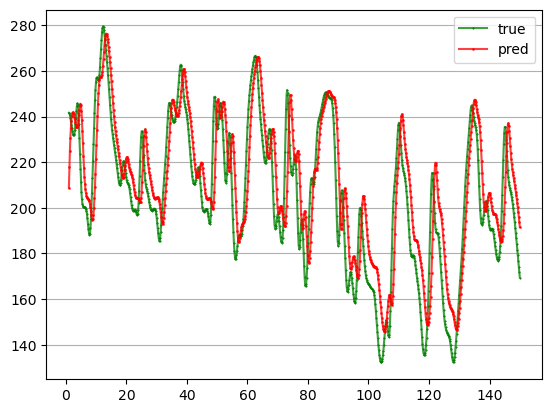

In [11]:

# curPath = os.path.abspath(os.path.dirname(__file__))
# rootPath = os.path.split(curPath)[0]
# sys.path.append(rootPath)

setup_seed(20)
path = os.path.abspath(os.path.dirname(os.getcwd()))
LSTM_PATH = path + '/models/Univariate_single_step_Lst.pkl' #最佳模型保存路径
LSTM_PATH = LSTM_PATH.replace("\\", "/") #torch.save()不能保存windows路径，需要替换

file_name='data.csv'
data=load_data(file_name)
arg = args.us_args_parser() #导入单步模型参数
flag = 'us' # 表示使用单变量单步长的数据

Dtr, Val, Dte, m, n = data_process(data,arg, flag)   
train(arg, Dtr, Val, LSTM_PATH)
test(arg, Dte, LSTM_PATH, m, n)


# 3PyTorch中利用LSTMCell搭建多层LSTM实现时间序列预测

C:\Users\LYH\AppData\Local\Temp\ipykernel_21892\3448789555.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols].fillna(df[num_cols].mean(), inplace=True) #填补缺失值


data processing...


 67%|██████▋   | 50/75 [12:27<06:13, 14.92s/it]

epoch 049 train_loss 0.00251338 val_loss 0.00218568


100%|██████████| 75/75 [18:39<00:00, 14.92s/it]


loading models...
predicting...


100%|██████████| 175/175 [00:01<00:00, 163.90it/s]


mape: 0.06430463409283052


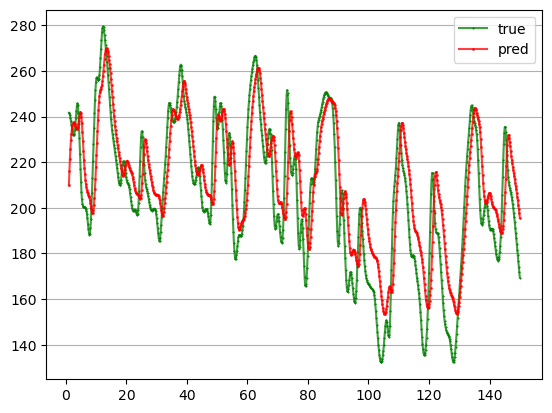

In [12]:
setup_seed(20)
path = os.path.abspath(os.path.dirname(os.getcwd()))
LSTM_PATH = path + '/models/Univariate_single_step_LstmCells.pkl' #最佳模型保存路径
LSTM_PATH = LSTM_PATH.replace("\\", "/") #torch.save()不能保存windows路径，需要替换

file_name='data.csv'
data=load_data(file_name)
arg = args.us_args_parser() #导入单步模型参数
flag = 'us' # 表示使用单变量单步长的数据

Dtr, Val, Dte, m, n = data_process(data,arg, flag)   
train(arg, Dtr, Val, LSTM_PATH,cells=1)
test(arg, Dte, LSTM_PATH, m, n,cells=1)

# 4.PyTorch搭建LSTM实现多变量时间序列预测（负荷预测）

C:\Users\LYH\AppData\Local\Temp\ipykernel_21892\3448789555.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols].fillna(df[num_cols].mean(), inplace=True) #填补缺失值


data processing...


 67%|██████▋   | 50/75 [01:44<00:48,  1.93s/it]

epoch 049 train_loss 0.00168948 val_loss 0.00185118


100%|██████████| 75/75 [02:30<00:00,  2.01s/it]


loading models...
predicting...


100%|██████████| 175/175 [00:00<00:00, 1459.09it/s]


mape: 0.0588469134396226


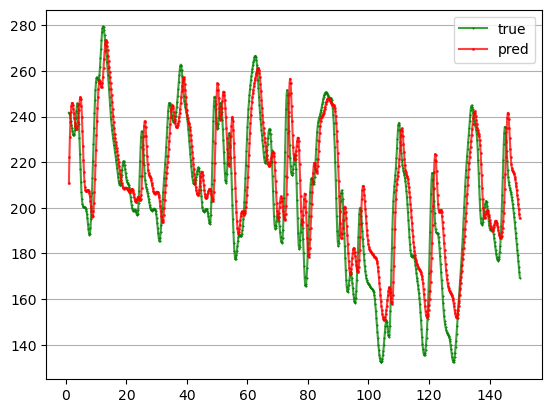

In [15]:
setup_seed(20)
path = os.path.abspath(os.path.dirname(os.getcwd()))
LSTM_PATH = path + '/models/Multivariable_single_step_Lstm.pkl'
LSTM_PATH = LSTM_PATH.replace("\\", "/") #torch.save()不能保存windows路径，需要替换

file_name='data.csv'
data=load_data(file_name)
arg = args.ms_args_parser() 
arg.bidirectional = False #多变量单步处理中设置单向LSTM

flag = 'ms' # 表示使用多变量单步长的数据

Dtr, Val, Dte, m, n = data_process(data,arg, flag)   
train(arg, Dtr, Val, LSTM_PATH)
test(arg, Dte, LSTM_PATH, m, n)

# 5.PyTorch搭建双向LSTM实现时间序列预测（负荷预测）

从你打印的 `seq` 大小来看，大部分的 `seq` 大小都是 `[30, 24, 7]`，这可能是你的批量大小为30，序列长度为24，每个序列有7个特征。然而，有一个 `seq` 的大小是 `[24, 24, 7]`，这可能是因为在数据的最后一个批次，数据不足以形成一个完整的批次，所以大小变为了24。

这就是为什么你的模型期望的隐藏层大小为 `(2, 24, 64)`，但实际得到的隐藏层大小为 `[2, 30, 64]`。你的模型可能是基于批量大小为24来设计的，但大部分的 `seq` 大小都是30。

原来的双向LSTM模型隐藏层构建有问题,在初始化隐藏状态 ho 和c0时，使用了固定的批量大小self.batch size 。
这意味着，无论输入数据的批量大小是多少，隐藏状态的批量大小总是固定的。
  
这就是为什么当最后一个输入数据的批量大小少于self.batch size 时，会遇到问题。解决办法：

1. **丢弃最后一个批次**：在创建 `DataLoader` 时，你可以设置 `drop_last=True`，这样在最后一个批次数据不足时，它会被丢弃，不会被送入模型。
2. **修改模型**：在前向传播时.通过 input seq.size(o)动态地获取批量大小，然后用这个批量大小来初始化隐藏状态,避免最后一个批次样本量不足时，导致批次大小和预期的不匹配

C:\Users\LYH\AppData\Local\Temp\ipykernel_20196\3448789555.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols].fillna(df[num_cols].mean(), inplace=True) #填补缺失值


data processing...


 67%|██████▋   | 50/75 [02:08<01:05,  2.62s/it]

epoch 049 train_loss 0.00170305 val_loss 0.00195474


100%|██████████| 75/75 [03:12<00:00,  2.56s/it]


loading models...
predicting...


100%|██████████| 175/175 [00:00<00:00, 1132.64it/s]


mape: 0.05761943833800664


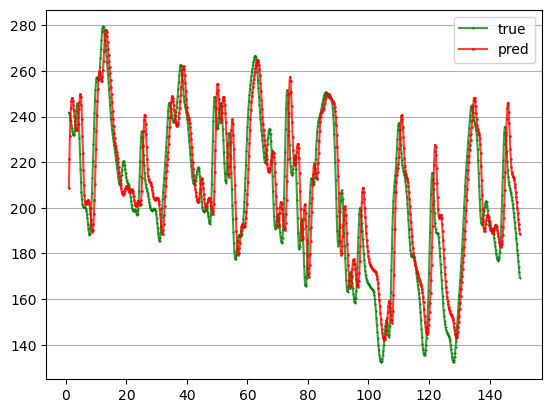

In [54]:
#原来的双向LSTM构建的不好，又没有修改DataLoader的drop_last，导致最后一个批次样本量不足30，所以报错了
setup_seed(20)
path = os.path.abspath(os.path.dirname(os.getcwd()))
LSTM_PATH = path + '/models/Multivariable_single_step_BiLstm.pkl'
LSTM_PATH = LSTM_PATH.replace("\\", "/") #torch.save()不能保存windows路径，需要替换

file_name='data.csv'
data=load_data(file_name)
arg = args.ms_args_parser()
arg.bidirectional = True #双向LSTM
flag = 'ms' # 表示使用多变量单步长的数据

Dtr, Val, Dte, m, n = data_process(data,arg, flag)   
train(arg, Dtr, Val, LSTM_PATH)
test(arg, Dte, LSTM_PATH, m, n)

# 6.PyTorch搭建LSTM实现多变量多步长时间序列预测（一）：直接多输出

C:\Users\LYH\AppData\Local\Temp\ipykernel_20196\3448789555.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols].fillna(df[num_cols].mean(), inplace=True) #填补缺失值
100%|██████████| 50/50 [02:06<00:00,  2.53s/it]


epoch 049 train_loss 0.00322936 val_loss 0.00440618
loading models...
predicting...


100%|██████████| 43/43 [00:00<00:00, 1021.09it/s]

mape: 0.08271300903288134


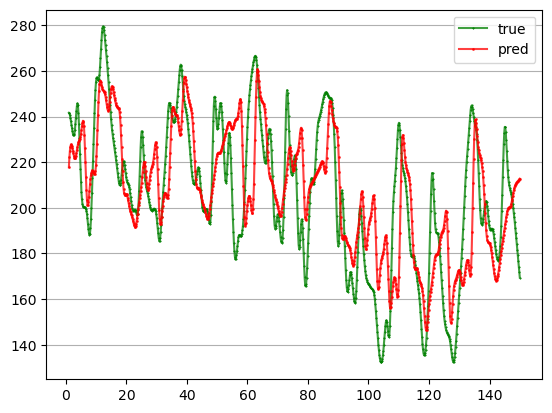

In [55]:
#原word用的是双向LSTM,CSDN是单向LSTM
setup_seed(20)
path = os.path.abspath(os.path.dirname(os.getcwd()))
LSTM_PATH = path + '/models/Multivariable_multi_step_BiLstm.pkl'
LSTM_PATH = LSTM_PATH.replace("\\", "/") #torch.save()不能保存windows路径，需要替换

file_name='data.csv'
data=load_data(file_name)
arg = args.mo_args_parser()
flag = 'mo' # 表示使用多变量单步长的数据

Dtr, Val, Dte, m, n = data_process(data,arg, flag)   
train(arg, Dtr, Val, LSTM_PATH)
test(arg, Dte, LSTM_PATH, m, n)

# 7.多变量多步长时间序列预测（二）：单步滚动预测

In [63]:
setup_seed(20)
path = os.path.abspath(os.path.dirname(os.getcwd()))
LSTM_PATH = path + '/models/Multivariable_multi_step_rolling.pkl'
LSTM_PATH = LSTM_PATH.replace("\\", "/") #torch.save()不能保存windows路径，需要替换

file_name='data.csv'
data=load_data(file_name)
arg = args.sss_args_parser()
flag = 'sss' 

Dtr, Val, Dte, m, n = data_process(data,arg, flag)   
train(arg, Dtr, Val, LSTM_PATH)
#test(arg, Dte, LSTM_PATH, m, n)
ss_rolling_test(arg, Dte, LSTM_PATH, m, n) #单步滚动预测的测试代码不一样

C:\Users\LYH\AppData\Local\Temp\ipykernel_20196\3448789555.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols].fillna(df[num_cols].mean(), inplace=True) #填补缺失值
 67%|██████▋   | 50/75 [01:38<00:49,  2.00s/it]

epoch 049 train_loss 0.00168249 val_loss 0.00186192


100%|██████████| 75/75 [02:27<00:00,  1.96s/it]


loading models...
predicting...


100%|██████████| 15/15 [00:00<00:00, 105.98it/s]


ValueError: operands could not be broadcast together with shapes (5220,) (174,) 

# 8.多变量多步长时间序列预测（三）：多模型单步预测

In [ ]:
# multi_model_single_step 多模型单步预测
setup_seed(20)
path = os.path.abspath(os.path.dirname(os.getcwd()))
LSTM_PATH = path + '/models/multi_model_single_step.pkl'
LSTM_PATH = LSTM_PATH.replace("\\", "/") #torch.save()不能保存windows路径，需要替换

file_name='data.csv'
data=load_data(file_name)
arg = args.mmss_args_parser()
flag = 'mmss' # 表示使用多变量单步长的数据

Dtr, Val, Dte, m, n = data_process(data,arg, flag)   
train(arg, Dtr, Val, LSTM_PATH)
test(arg, Dte, LSTM_PATH, m, n)

# 9.多变量多步长时间序列预测（四）：多模型滚动预测

In [ ]:
# multi_model_scrolling 多模型滚动预测
setup_seed(20)
path = os.path.abspath(os.path.dirname(os.getcwd()))
LSTM_PATH = path + '/models/Multivariable_multi_step_multirolling.pkl'
LSTM_PATH = LSTM_PATH.replace("\\", "/") #torch.save()不能保存windows路径，需要替换

file_name='data.csv'
data=load_data(file_name)
arg = args.mms_args_parser()
flag = 'mms' # 表示使用多变量单步长的数据

Dtr, Val, Dte, m, n = data_process(data,arg, flag)   
train(arg, Dtr, Val, LSTM_PATH)
test(arg, Dte, LSTM_PATH, m, n)

# 10.多变量多步长时间序列预测（五）：seq2seq

# 13.PyTorch搭建LSTM实现多变量输入多变量输出时间序列预测（多任务学习）

# 15.PyTorch搭建CNN实现时间序列预测（风速预测）